In [1]:
import xml.etree.ElementTree as ET

def parse_mif300_interactions(path):
    tree = ET.parse(path)
    root = tree.getroot()

    def S(tag):  # strip namespace
        return tag.split('}', 1)[1] if tag.startswith('{') else tag

    interactions = []
    for inter in root.iter():
        if S(inter.tag) != 'interaction':
            continue

        # find participant list (some records place participants directly under <interaction>)
        plist = None
        for c in inter:
            if S(c.tag) == 'participantList':
                plist = c
                break
        if plist is None:
            plist = inter

        parts = []
        for pnode in plist:
            if S(pnode.tag) != 'participant':
                continue

            # Case 1: by reference
            ir = pnode.find('.//{*}interactorRef')
            if ir is not None and ir.text:
                parts.append(('REF', ir.text, None))
                continue

            # Case 2: inline interactor
            inter_el = pnode.find('.//{*}interactor')
            if inter_el is not None:
                xref = inter_el.find('.//{*}xref')
                pref = xref.find('.//{*}primaryRef') if xref is not None else None
                db   = pref.get('db') if pref is not None else None
                acc  = pref.get('id') if pref is not None else None

                names = inter_el.find('.//{*}names')
                sl = names.find('.//{*}shortLabel') if names is not None else None
                short = sl.text if sl is not None else None

                parts.append((db, acc, short))

        interactions.append(parts)

    return interactions

ints = parse_mif300_interactions("2025-10-28-21-18.xml")
print("Interactions:", len(ints))
for i, parts in enumerate(ints):
    print(f"#{i}: {len(parts)} participants ->", parts)


Interactions: 7
#0: 2 participants -> [('uniprotkb', 'P0DTD1', 'r1ab_sars2'), ('uniprotkb', 'P0DTD1-PRO_0000449623', 'p0dtd1-pro_0000449623')]
#1: 2 participants -> [('uniprotkb', 'P0DTD1', 'r1ab_sars2'), ('uniprotkb', 'P0DTD1-PRO_0000449623', 'p0dtd1-pro_0000449623')]
#2: 2 participants -> [('uniprotkb', 'P0DTD1', 'r1ab_sars2'), ('uniprotkb', 'P0DTD1-PRO_0000449621', 'p0dtd1-pro_0000449621')]
#3: 2 participants -> [('intact', 'EBI-25498052', 'mca-avlqsgfr-lys(dnp)-lys-nh2'), ('uniprotkb', 'P0DTD1', 'r1ab_sars2')]
#4: 2 participants -> [('chebi', 'CHEBI:147398', 'tideglusib'), ('uniprotkb', 'P0DTD1', 'r1ab_sars2')]
#5: 2 participants -> [('uniprotkb', 'P0DTD1-PRO_0000449621', 'p0dtd1-pro_0000449621'), ('uniprotkb', 'P0DTD1', 'r1ab_sars2')]
#6: 2 participants -> [('uniprotkb', 'P0DTD1-PRO_0000449621', 'p0dtd1-pro_0000449621'), ('uniprotkb', 'P0DTD1', 'r1ab_sars2')]


In [2]:
import pandas as pd
import os 

def organize_cv(
    path="/scratch/pranamlab/sophie/interactome/interactome/data_files/raw/intact/cv/intact.obo",
    starting_id="MI:0190",
    out_dir="/scratch/pranamlab/sophie/interactome/interactome/data_files/processed/intact/cv",
):
    """
    Organize IntAct PSI-MI OBO into a CSV subtree rooted at `starting_id`.

    Output columns:
      - id:              term id
      - label:           term name
      - parent_id:       the direct parent along the traversed edge (one per row)
      - parent_ids_all:  comma-separated *all* is_a parent ids for this term
      - parent_names_all:comma-separated *all* is_a parent names for this term
    """

    # -------- Parse OBO into terms dict --------
    # terms[id] = {"name": str, "is_a": [parent_ids]}
    terms = {}
    current = None

    def _commit(curr):
        if not curr:
            return
        if "id" in curr and "name" in curr:
            terms[curr["id"]] = {
                "name": curr["name"],
                "is_a": curr.get("is_a", []),
            }

    with open(path, "r", encoding="utf-8") as f:
        for raw in f:
            line = raw.strip()
            if line == "[Term]":
                # Commit previous term before starting a new one
                _commit(current)
                current = {}
                continue
            if not line:
                # Blank line ends a stanza
                _commit(current)
                current = None
                continue

            if current is None:
                # Skip header or [Typedef] sections, etc.
                continue

            if line.startswith("id:"):
                current["id"] = line[3:].strip()
            elif line.startswith("name:"):
                current["name"] = line[5:].strip()
            elif line.startswith("is_a:"):
                # Keep only the ID portion before "!"
                parent_id = line[5:].split("!")[0].strip()
                current.setdefault("is_a", []).append(parent_id)

    # Commit last term if file doesn't end with a blank line
    _commit(current)

    # -------- Build reverse index for traversal --------
    children_map = {}
    for term_id, meta in terms.items():
        for p in meta.get("is_a", []):
            children_map.setdefault(p, []).append(term_id)

    # -------- Traverse subtree from starting_id --------
    results = []

    def traverse(term_id, parent_id=None):
        if term_id not in terms:
            return
        meta = terms[term_id]
        all_parents = meta.get("is_a", [])
        # Map parent IDs → names if present
        parent_names = [terms[p]["name"] for p in all_parents if p in terms]

        results.append({
            "label": meta["name"],
            "id": term_id,
            "parent_id": parent_id,  # edge used to reach this node
            "parent_ids_all": ", ".join(all_parents) if all_parents else "",
            "parent_names_all": ", ".join(parent_names) if parent_names else "",
        })

        for child in children_map.get(term_id, []):
            traverse(child, parent_id=term_id)

    traverse(starting_id)

    df = pd.DataFrame(results).drop_duplicates()

    os.makedirs(out_dir, exist_ok=True)
    out_path = f"{out_dir}/{starting_id.lower().replace(':','_')}_subtree.csv"
    df.to_csv(out_path, index=False)
    return out_path

organize_cv(starting_id="MI:0190")
organize_cv(starting_id="MI:0915")
organize_cv(starting_id="MI:0407")
organize_cv(starting_id="MI:0118")
organize_cv(starting_id="MI:0925")
organize_cv(starting_id="MI:0117")


'/scratch/pranamlab/sophie/interactome/interactome/data_files/processed/intact/cv/mi_0117_subtree.csv'

In [4]:
s = "MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHLKDGTCGLVEVEKGVLPQLEQPYVFIKRSDARTAPHGHVMVELVAELEGIQYGRSGETLGVLVPHVGEIPVAYRKVLLRKNGNKGAGGHSYGADLKSFDLGDELGTDPYEDFQENWNTKHSSGVTRELMRELNGGAYTRYVDNNFCGPDGYPLECIKDLLARAGKASCTLSEQLDFIDTKRGVYCCREHEHEIAWYTERSEKSYELQTPFEIKLAKKFDTFNGECPNFVFPLNSIIKTIQPRVEKKKLDGFMGRIRSVYPVASPNECNQMCLSTLMKCDHCGETSWQTGDFVKATCEFCGTENLTKEGATTCGYLPQNAVVKIYCPACHNSEVGPEHSLAEYHNESGLKTILRKGGRTIAFGGCVFSYVGCHNKCAYWVPRASANIGCNHTGVVGEGSEGLNDNLLEILQKEKVNINIVGDFKLNEEIAIILASFSASTSAFVETVKGLDYKAFKQIVESCGNFKVTKGKAKKGAWNIGEQKSILSPLYAFASEAARVVRSIFSRTLETAQNSVRVLQKAAITILDGISQYSLRLIDAMMFTSDLATNNLVVMAYITGGVVQLTSQWLTNIFGTVYEKLKPVLDWLEEKFKEGVEFLRDGWEIVKFISTCACEIVGGQIVTCAKEIKESVQTFFKLVNKFLALCADSIIIGGAKLKALNLGETFVTHSKGLYRKCVKSREETGLLMPLKAPKEIIFLEGETLPTEVLTEEVVLKTGDLQPLEQPTSEAVEAPLVGTPVCINGLMLLEIKDTEKYCALAPNMMVTNNTFTLKGGAPTKVTFGDDTVIEVQGYKSVNITFELDERIDKVLNEKCSAYTVELGTEVNEFACVVADAVIKTLQPVSELLTPLGIDLDEWSMATYYLFDESGEFKLASHMYCSFYPPDEDEEEGDCEEEEFEPSTQYEYGTEDDYQGKPLEFGATSAALQPEEEQEEDWLDDDSQQTVGQQDGSEDNQTTTIQTIVEVQPQLEMELTPVVQTIEVNSFSGYLKLTDNVYIKNADIVEEAKKVKPTVVVNAANVYLKHGGGVAGALNKATNNAMQVESDDYIATNGPLKVGGSCVLSGHNLAKHCLHVVGPNVNKGEDIQLLKSAYENFNQHEVLLAPLLSAGIFGADPIHSLRVCVDTVRTNVYLAVFDKNLYDKLVSSFLEMKSEKQVEQKIAEIPKEEVKPFITESKPSVEQRKQDDKKIKACVEEVTTTLEETKFLTENLLLYIDINGNLHPDSATLVSDIDITFLKKDAPYIVGDVVQEGVLTAVVIPTKKAGGTTEMLAKALRKVPTDNYITTYPGQGLNGYTVEEAKTVLKKCKSAFYILPSIISNEKQEILGTVSWNLREMLAHAEETRKLMPVCVETKAIVSTIQRKYKGIKIQEGVVDYGARFYFYTSKTTVASLINTLNDLNETLVTMPLGYVTHGLNLEEAARYMRSLKVPATVSVSSPDAVTAYNGYLTSSSKTPEEHFIETISLAGSYKDWSYSGQSTQLGIEFLKRGDKSVYYTSNPTTFHLDGEVITFDNLKTLLSLREVRTIKVFTTVDNINLHTQVVDMSMTYGQQFGPTYLDGADVTKIKPHNSHEGKTFYVLPNDDTLRVEAFEYYHTTDPSFLGRYMSALNHTKKWKYPQVNGLTSIKWADNNCYLATALLTLQQIELKFNPPALQDAYYRARAGEAANFCALILAYCNKTVGELGDVRETMSYLFQHANLDSCKRVLNVVCKTCGQQQTTLKGVEAVMYMGTLSYEQFKKGVQIPCTCGKQATKYLVQQESPFVMMSAPPAQYELKHGTFTCASEYTGNYQCGHYKHITSKETLYCIDGALLTKSSEYKGPITDVFYKENSYTTTIKPVTYKLDGVVCTEIDPKLDNYYKKDNSYFTEQPIDLVPNQPYPNASFDNFKFVCDNIKFADDLNQLTGYKKPASRELKVTFFPDLNGDVVAIDYKHYTPSFKKGAKLLHKPIVWHVNNATNKATYKPNTWCIRCLWSTKPVETSNSFDVLKSEDAQGMDNLACEDLKPVSEEVVENPTIQKDVLECNVKTTEVVGDIILKPANNSLKITEEVGHTDLMAAYVDNSSLTIKKPNELSRVLGLKTLATHGLAAVNSVPWDTIANYAKPFLNKVVSTTTNIVTRCLNRVCTNYMPYFFTLLLQLCTFTRSTNSRIKASMPTTIAKNTVKSVGKFCLEASFNYLKSPNFSKLINIIIWFLLLSVCLGSLIYSTAALGVLMSNLGMPSYCTGYREGYLNSTNVTIATYCTGSIPCSVCLSGLDSLDTYPSLETIQITISSFKWDLTAFGLVAEWFLAYILFTRFFYVLGLAAIMQLFFSYFAVHFISNSWLMWLIINLVQMAPISAMVRMYIFFASFYYVWKSYVHVVDGCNSSTCMMCYKRNRATRVECTTIVNGVRRSFYVYANGGKGFCKLHNWNCVNCDTFCAGSTFISDEVARDLSLQFKRPINPTDQSSYIVDSVTVKNGSIHLYFDKAGQKTYERHSLSHFVNLDNLRANNTKGSLPINVIVFDGKSKCEESSAKSASVYYSQLMCQPILLLDQALVSDVGDSAEVAVKMFDAYVNTFSSTFNVPMEKLKTLVATAEAELAKNVSLDNVLSTFISAARQGFVDSDVETKDVVECLKLSHQSDIEVTGDSCNNYMLTYNKVENMTPRDLGACIDCSARHINAQVAKSHNIALIWNVKDFMSLSEQLRKQIRSAAKKNNLPFKLTCATTRQVVNVVTTKIALKGGKIVNNWLKQLIKVTLVFLFVAAIFYLITPVHVMSKHTDFSSEIIGYKAIDGGVTRDIASTDTCFANKHADFDTWFSQRGGSYTNDKACPLIAAVITREVGFVVPGLPGTILRTTNGDFLHFLPRVFSAVGNICYTPSKLIEYTDFATSACVLAAECTIFKDASGKPVPYCYDTNVLEGSVAYESLRPDTRYVLMDGSIIQFPNTYLEGSVRVVTTFDSEYCRHGTCERSEAGVCVSTSGRWVLNNDYYRSLPGVFCGVDAVNLLTNMFTPLIQPIGALDISASIVAGGIVAIVVTCLAYYFMRFRRAFGEYSHVVAFNTLLFLMSFTVLCLTPVYSFLPGVYSVIYLYLTFYLTNDVSFLAHIQWMVMFTPLVPFWITIAYIICISTKHFYWFFSNYLKRRVVFNGVSFSTFEEAALCTFLLNKEMYLKLRSDVLLPLTQYNRYLALYNKYKYFSGAMDTTSYREAACCHLAKALNDFSNSGSDVLYQPPQTSITSAVLQSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQSAVKRTIKGTHHWLLLTILTSLLVLVQSTQWSLFFFLYENAFLPFAMGIIAMSAFAMMFVKHKHAFLCLFLLPSLATVAYFNMVYMPASWVMRIMTWLDMVDTSLSGFKLKDCVMYASAVVLLILMTARTVYDDGARRVWTLMNVLTLVYKVYYGNALDQAISMWALIISVTSNYSGVVTTVMFLARGIVFMCVEYCPIFFITGNTLQCIMLVYCFLGYFCTCYFGLFCLLNRYFRLTLGVYDYLVSTQEFRYMNSQGLLPPKNSIDAFKLNIKLLGVGGKPCIKVATVQSKMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTTEAFEKMVSLLSVLLSMQGAVDINKLCEEMLDNRATLQAIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAMQRKLEKMADQAMTQMYKQARSEDKRAKVTSAMQTMLFTMLRKLDNDALNNIINNARDGCVPLNIIPLTTAAKLMVVIPDYNTYKNTCDGTTFTYASALWEIQQVVDADSKIVQLSEISMDNSPNLAWPLIVTALRANSAVKLQNNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLSDLQDLKWARFPKSDGTGTIYTELEPPCRFVTDTPKGPKVKYLYFIKGLNNLNRGMVLGSLAATVRLQAGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLCTHTGTGQAITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPVGFTLKNTVCTVCGMWKGYGCSCDQLREPMLQSADAQSFLNRVCGVSAARLTPCGTGTSTDVVYRAFDIYNDKVAGFAKFLKTNCCRFQEKDEDDNLIDSYFVVKRHTFSNYQHEETIYNLLKDCPAVAKHDFFKFRIDGDMVPHISRQRLTKYTMADLVYALRHFDEGNCDTLKEILVTYNCCDDDYFNKKDWYDFVENPDILRVYANLGERVRQALLKTVQFCDAMRNAGIVGVLTLDNQDLNGNWYDFGDFIQTTPGSGVPVVDSYYSLLMPILTLTRALTAESHVDTDLTKPYIKWDLLKYDFTEERLKLFDRYFKYWDQTYHPNCVNCLDDRCILHCANFNVLFSTVFPPTSFGPLVRKIFVDGVPFVVSTGYHFRELGVVHNQDVNLHSSRLSFKELLVYAADPAMHAASGNLLLDKRTTCFSVAALTNNVAFQTVKPGNFNKDFYDFAVSKGFFKEGSSVELKHFFFAQDGNAAISDYDYYRYNLPTMCDIRQLLFVVEVVDKYFDCYDGGCINANQVIVNNLDKSAGFPFNKWGKARLYYDSMSYEDQDALFAYTKRNVIPTITQMNLKYAISAKNRARTVAGVSICSTMTNRQFHQKLLKSIAATRGATVVIGTSKFYGGWHNMLKTVYSDVENPHLMGWDYPKCDRAMPNMLRIMASLVLARKHTTCCSLSHRFYRLANECAQVLSEMVMCGGSLYVKPGGTSSGDATTAYANSVFNICQAVTANVNALLSTDGNKIADKYVRNLQHRLYECLYRNRDVDTDFVNEFYAYLRKHFSMMILSDDAVVCFNSTYASQGLVASIKNFKSVLYYQNNVFMSEAKCWTETDLTKGPHEFCSQHTMLVKQGDDYVYLPYPDPSRILGAGCFVDDIVKTDGTLMIERFVSLAIDAYPLTKHPNQEYADVFHLYLQYIRKLHDELTGHMLDMYSVMLTNDNTSRYWEPEFYEAMYTPHTVLQAVGACVLCNSQTSLRCGACIRRPFLCCKCCYDHVISTSHKLVLSVNPYVCNAPGCDVTDVTQLYLGGMSYYCKSHKPPISFPLCANGQVFGLYKNTCVGSDNVTDFNAIATCDWTNAGDYILANTCTERLKLFAAETLKATEETFKLSYGIATVREVLSDRELHLSWEVGKPRPPLNRNYVFTGYRVTKNSKVQIGEYTFEKGDYGDAVVYRGTTTYKLNVGDYFVLTSHTVMPLSAPTLVPQEHYVRITGLYPTLNISDEFSSNVANYQKVGMQKYSTLQGPPGTGKSHFAIGLALYYPSARIVYTACSHAAVDALCEKALKYLPIDKCSRIIPARARVECFDKFKVNSTLEQYVFCTVNALPETTADIVVFDEISMATNYDLSVVNARLRAKHYVYIGDPAQLPAPRTLLTKGTLEPEYFNSVCRLMKTIGPDMFLGTCRRCPAEIVDTVSALVYDNKLKAHKDKSAQCFKMFYKGVITHDVSSAINRPQIGVVREFLTRNPAWRKAVFISPYNSQNAVASKILGLPTQTVDSSQGSEYDYVIFTQTTETAHSCNVNRFNVAITRAKVGILCIMSDRDLYDKLQFTSLEIPRRNVATLQAENVTGLFKDCSKVITGLHPTQAPTHLSVDTKFKTEGLCVDIPGIPKDMTYRRLISMMGFKMNYQVNGYPNMFITREEAIRHVRAWIGFDVEGCHATREAVGTNLPLQLGFSTGVNLVAVPTGYVDTPNNTDFSRVSAKPPPGDQFKHLIPLMYKGLPWNVVRIKIVQMLSDTLKNLSDRVVFVLWAHGFELTSMKYFVKIGPERTCCLCDRRATCFSTASDTYACWHHSIGFDYVYNPFMIDVQQWGFTGNLQSNHDLYCQVHGNAHVASCDAIMTRCLAVHECFVKRVDWTIEYPIIGDELKINAACRKVQHMVVKAALLADKFPVLHDIGNPKAIKCVPQADVEWKFYDAQPCSDKAYKIEELFYSYATHSDKFTDGVCLFWNCNVDRYPANSIVCRFDTRVLSNLNLPGCDGGSLYVNKHAFHTPAFDKSAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHHANEYRLYLDAYNMMISAGFSLWVYKQFDTYNLWNTFTRLQSLENVAFNVVNKGHFDGQQGEVPVSIINNTVYTKVDGVDVELFENKTTLPVNVAFELWAKRNIKPVPEVKILNNLGVDIAANTVIWDYKRDAPAHISTIGVCSMTDIAKKPTETICAPLTVFFDGRVDGQVDLFRNARNGVLITEGSVKGLQPSVGPKQASLNGVTLIGEAVKTQFNYYKKVDGVVQQLPETYFTQSRNLQEFKPRSQMEIDFLELAMDEFIERYKLEGYAFEHIVYGDFSHSQLGGLHLLIGLAKRFKESPFELEDFIPMDSTVKNYFITDAQTGSSKCVCSVIDLLLDDFVEIIKSQDLSVVSKVVKVTIDYTEISFMLWCKDGHVETFYPKLQSSQAWQPGVAMPNLYKMQRMLLEKCDLQNYGDSATLPKGIMMNVAKYTQLCQYLNTLTLAVPYNMRVIHFGAGSDKGVAPGTAVLRQWLPTGTLLVDSDLNDFVSDADSTLIGDCATVHTANKWDLIISDMYDPKTKNVTKENDSKEGFFTYICGFIQQKLALGGSVAIKITEHSWNADLYKLMGHFAWWTAFVTNVNASSSEAFLIGCNYLGKPREQIDGYVMHANYIFWRNTNPIQLSSYSLFDMSKFPLKLRGTAVMSLKEGQINDMILSLLSKGRLIIRENNRVVISSDVLVNN"
substr = s[3263:3569]
print(len(substr))
targetsub = "SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ"
print(len(targetsub))
substr==targetsub

306
306


True

In [5]:
# Load 
import pandas as pd
ptms_path = "data_files/raw/intact/psimitab/features/ptms.tsv"
ptms = pd.read_csv(ptms_path, sep="\t", engine="python")
ptms.loc[
    ptms["Feature annotation(s)"].fillna("").str.contains("decreasing")
]

,# Feature AC,Feature short label,Feature range(s),Original sequence,Resulting sequence,Feature type,Feature annotation(s),Affected protein AC,Affected protein symbol,Affected protein full name,Affected protein organism,Interaction participants,PubMedID,Figure legend(s),Interaction AC,Xref ID(s)
960,EBI-9693840,decreasing_ser37_and/or_thr41,"37-37,41-41","S,T",",","psi-mi:""MI:0170""(phosphorylated residue)",ptm decreasing an interaction,uniprotkb:P35222,uniprotkb:CTNNB1(gene name),Catenin beta-1,taxid:9606(human)|taxid:9606(Homo sapiens),"(uniprotkb:P35222(psi-mi:""MI:0326""(protein)), ...",pubmed:21118991|imex:IM-22907,figure legend:Fig. 2A,EBI-9550019,-
1081,EBI-9698757,tyr283,282-283,SY,-,"psi-mi:""MI:0176""(O-phospho-L-serine)",ptm decreasing an interaction,uniprotkb:P14921-1,uniprotkb:ETS1(gene name),Protein C-ets-1,taxid:9606(human)|taxid:9606(Homo sapiens),"(uniprotkb:P14921-1(psi-mi:""MI:0326""(protein))...",pubmed:25117710|imex:IM-23043,figure legend:3B,EBI-9698678,-
3739,EBI-16197638,K4me2,4-4,K,-,"psi-mi:""MI:0166""(N6,N6-dimethyl-L-lysine)",observed-ptm:PTM decreasing an interaction,dip:DIP-29604N,-,H3K9 peptide,"taxid:-2(chemical synthesis)|taxid:-2(""Chemica...","(uniprotkb:Q9SU24(psi-mi:""MI:0326""(protein)), ...",pubmed:26876097|imex:IM-25261,-,EBI-16197627,-
3750,EBI-16197635,K4me1,4-4,K,-,"psi-mod:""MOD:01683""(monomethylated L-lysine)",observed-ptm:PTM decreasing an interaction,dip:DIP-29604N,-,H3K9 peptide,"taxid:-2(chemical synthesis)|taxid:-2(""Chemica...","(uniprotkb:Q9SU24(psi-mi:""MI:0326""(protein)), ...",pubmed:26876097|imex:IM-25261,-,EBI-16197627,-
3758,EBI-16197605,K4me2,4-4,K,-,"psi-mi:""MI:0166""(N6,N6-dimethyl-L-lysine)",observed-ptm:PTM decreasing an interaction,dip:DIP-29604N,-,H3K9 peptide,"taxid:-2(chemical synthesis)|taxid:-2(""Chemica...","(uniprotkb:Q710E8(psi-mi:""MI:0326""(protein)), ...",pubmed:26876097|imex:IM-25261,-,EBI-16197597,-
3769,EBI-16197602,K4me1,4-4,K,-,"psi-mod:""MOD:01683""(monomethylated L-lysine)",observed-ptm:PTM decreasing an interaction,dip:DIP-29604N,-,H3K9 peptide,"taxid:-2(chemical synthesis)|taxid:-2(""Chemica...","(uniprotkb:Q710E8(psi-mi:""MI:0326""(protein)), ...",pubmed:26876097|imex:IM-25261,-,EBI-16197597,-
3871,EBI-16197650,R2me1,2-2,R,-,"psi-mod:""MOD:00414""(monomethylated L-arginine)",observed-ptm:PTM decreasing an interaction,dip:DIP-29604N,-,H3K9 peptide,"taxid:-2(chemical synthesis)|taxid:-2(""Chemica...","(uniprotkb:Q9SU24(psi-mi:""MI:0326""(protein)), ...",pubmed:26876097|imex:IM-25261,-,EBI-16197627,-
4350,EBI-9635498,decreasing_ser37_and/or_thr41,"37-37,41-41","S,T",",","psi-mi:""MI:0170""(phosphorylated residue)",ptm decreasing an interaction,uniprotkb:P35222,uniprotkb:CTNNB1(gene name),Catenin beta-1,taxid:9606(human)|taxid:9606(Homo sapiens),"(uniprotkb:O95071(psi-mi:""MI:0326""(protein)), ...",pubmed:21118991|imex:IM-22907,"figure legend:Fig.2A, 4C",EBI-9549998,-
4892,EBI-6875383,ser780-ser788-ser795-ser807-ser811-thr821-thr826,"780-780,788-788,795-795,807-807,811-811,821-82...","S,S,S,S,S,T,T",",,,,,,","psi-mod:""MOD:01456""(N-phosphorylated residue)",ptm decreasing an interaction:Phosphorylation ...,uniprotkb:P06400,uniprotkb:RB1(gene name),Retinoblastoma-associated protein,taxid:9606(human)|taxid:9606(Homo sapiens),"(uniprotkb:Q01094(psi-mi:""MI:0326""(protein)), ...",pubmed:16360038|imex:IM-20931,"figure legend:Fig. 1c, Fig. 1d, Fig. 5a, Suppl...",EBI-6858555,-
8138,EBI-9698436,tyr283,283-283,Y,-,"psi-mi:""MI:0178""(O4'-phospho-L-tyrosine)",ptm decreasing an interaction,uniprotkb:P14921-1,uniprotkb:ETS1(gene name),Protein C-ets-1,taxid:9606(human)|taxid:9606(Homo sapiens),"(uniprotkb:Q8NHY2(psi-mi:""MI:0326""(protein)), ...",pubmed:25117710|imex:IM-23043,figure legend:3A,EBI-9698413,-


In [4]:
import torch
import pickle
import torch.nn.functional as F
import pandas as pd

def load_embeddings(embeddings_savepath):
    """
    Load embeddings 
    Works on .pt or .pkl
    """
    if embeddings_savepath.endswith(".pt"):
        bundle = torch.load(embeddings_savepath, map_location="cpu")
        E = bundle["embeddings"]               # (N, D) tensor
        ids = bundle["ids"]
        embeddings = {i: E[idx] for idx, i in enumerate(ids)}
        return embeddings
    elif embeddings_savepath.endswith(".pkl"):
        with open(embeddings_savepath, "rb") as f:
            embeddings = pickle.load(f)
        return embeddings
    else:
        raise Exception(f"No pipeline implemented to load embeddings of this filetype. path = {embeddings_savepath}")
    
def calculate_distance(x, y, distance_type, return_pt=True):
    """
    Calculate distance between embeddings
    x (np.array) or (torch.tensor)
    y (np.array) or (torch.tensor)
    distance_type (str): 'cosine' or 'euclidean'
    """
    # return cosine DISTANCE not similarity. So the more similar they are, the smaller the distance is.
    if type(x)!=torch.Tensor:
        x = torch.tensor(x)
    if type(y)!=torch.Tensor:
        y = torch.tensor(y)
    
    if x.shape[-1] != y.shape[-1]:
        raise ValueError(f"Last dims must match, got {x.shape[-1]} vs {y.shape[-1]}")

    d = None
    if distance_type in ("euclidean", "l2"):
        d = torch.linalg.vector_norm(x - y, ord=2, dim=-1)
    elif distance_type in ("manhattan", "l1"):
        d = torch.linalg.vector_norm(x - y, ord=1, dim=-1)
    elif distance_type in ("cosine", "cos"):
        # cosine *distance* = 1 - cosine similarity
        d = 1.0 - F.cosine_similarity(x, y, dim=-1, eps=1e-8)
    else:
        raise ValueError(f"Unknown distance_type: {distance_type}")

    if type(d)==torch.Tensor and not(return_pt):
        return d.item()
    return d

In [9]:
fusion_embeddings = load_embeddings("/scratch/pranamlab/sophie/SiameseCat/siamesecat/data_files/embeddings/fusondb/esm2_t33_650M_UR50D/fusions_max2046AAs.pt")
head_tail_embeddings = load_embeddings("/scratch/pranamlab/sophie/SiameseCat/siamesecat/data_files/embeddings/fusondb/esm2_t33_650M_UR50D/heads_tails_max2046AAs.pt")
embeddings = dict()
for seq_id, embedding in fusion_embeddings.items():
    embeddings[seq_id] = embedding
for seq_id, embedding in head_tail_embeddings.items():
    embeddings[seq_id] = embedding
print(len(embeddings))
embeddings

50304


{'seq1': tensor([ 0.0089, -0.0864,  0.0549,  ...,  0.0113,  0.0249, -0.0221]),
 'seq2': tensor([ 0.0143, -0.0845,  0.0364,  ..., -0.0267, -0.0020,  0.0074]),
 'seq3': tensor([ 0.0404, -0.0505,  0.0184,  ..., -0.1016,  0.0102,  0.0732]),
 'seq4': tensor([ 0.0428, -0.0418,  0.0200,  ..., -0.1062,  0.0044,  0.0681]),
 'seq5': tensor([-0.0088, -0.0424, -0.0408,  ..., -0.1306, -0.0673,  0.0451]),
 'seq6': tensor([-0.0235, -0.0325, -0.0303,  ..., -0.1274, -0.0646,  0.0496]),
 'seq7': tensor([ 0.0423,  0.0105, -0.0420,  ..., -0.1021, -0.0758,  0.0271]),
 'seq8': tensor([ 0.0401,  0.0070, -0.0391,  ..., -0.1013, -0.0661,  0.0261]),
 'seq9': tensor([ 0.0415,  0.0149, -0.0373,  ..., -0.0932, -0.0745,  0.0256]),
 'seq10': tensor([ 0.0511,  0.0457,  0.0184,  ...,  0.0574, -0.0446,  0.0796]),
 'seq11': tensor([ 0.0618,  0.0779,  0.0343,  ...,  0.0638, -0.0404,  0.0852]),
 'seq12': tensor([-0.0031, -0.0694, -0.0603,  ..., -0.0991,  0.0426,  0.1662]),
 'seq13': tensor([-0.0046, -0.0667, -0.0581,  ...

In [12]:
fusion_data= pd.read_csv("/scratch/pranamlab/sophie/SiameseCat/siamesecat/data_files/processed/fusondb/fusions_with_alignments.csv")
relationship_df = fusion_data.copy(deep=True)[[
    "seq_id","FusionGenes","Fusion_Seq","Hgene","Tgene","HG_Seq","TG_Seq","HG_seq_id","TG_seq_id"
]]
relationship_df = relationship_df.loc[
    (relationship_df["seq_id"].isin(embeddings.keys())) & 
    (relationship_df["HG_seq_id"].isin(embeddings.keys())) &
    (relationship_df["TG_seq_id"].isin(embeddings.keys()))
].reset_index(drop=True)

/tmp/ipykernel_2597073/2118163128.py:1: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  fusion_data= pd.read_csv("/scratch/pranamlab/sophie/SiameseCat/siamesecat/data_files/processed/fusondb/fusions_with_alignments.csv")


In [13]:
relationship_df

,seq_id,FusionGenes,Fusion_Seq,Hgene,Tgene,HG_Seq,TG_Seq,HG_seq_id,TG_seq_id
0,seq1,A1BG::FGA,MLQTLTPDTHCTGVSATIMSMLVVFLLLWGVTWGPVTEAAIYRDNT...,A1BG,FGA,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,MFSMRIVCLVLSVVGTAWTADSGEGDFLAEGGGVRGPRVVERHQSA...,htseq1,htseq5300
1,seq2,A1BG::FGA,MLQTLTPDTHCTGVSATIMSMLVVFLLLWGVTWGPVTEAAIYRDNT...,A1BG,FGA,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,MFSMRIVCLVLSVVGTAWTADSGEGDFLAEGGGVRGPRVVERHQSA...,htseq1,htseq5300
2,seq3,A1BG::ITIH4,MLQTLTPDTHCTGVSATIMSMLVVFLLLWGVTWGPVTEAAIFYETQ...,A1BG,ITIH4,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,MKPPRPVRTCSKVLVLLSLLAIHQTTTAEKNGIDIYSLTVDSRVSS...,htseq1,htseq2156
3,seq4,A1BG::ITIH4,MLQTLTPDTHCTGVSATIMSMLVVFLLLWGVTWGPVTEAAIFYETQ...,A1BG,ITIH4,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,MKPPRPVRTCSKVLVLLSLLAIHQTTTAEKNGIDIYSLTVDSRVSS...,htseq1,htseq2156
4,seq7,A2ML1::RBM39,MWAQLLLGMLALSPAIAEELPNYLVTLPARLNFPSVQKVCLDLSPG...,A2ML1,RBM39,MWAQLLLGMLALSPAIAEELPNYLVTLPARLNFPSVQKVCLDLSPG...,MADDIDIEAMLEAPYKKDENKLSSANGHEERSKKRKKSKSRSRSHE...,htseq2,htseq3747
...,...,...,...,...,...,...,...,...,...
26808,seq44405,ZSWIM5::EIF2B3,MPSRRAPGPGRGSPLGPAGSRVLSPRPPRRHRWALARGAWPWPGSP...,ZSWIM5,EIF2B3,MADGGEREELLSPSPVSPAKRQCSWPSPQAHHPRGSPGAAGGGAGG...,MEFQAVVMAVGGGSRMTDLTSSIPKPLLPVGNKPLIWYPLNLLERV...,htseq5297,htseq1363
26809,seq44406,ZSWIM5::EIF2B3,MPSRRAPGPGRGSPLGPAGSRVLSPRPPRRHRWALARGAWPWPGSP...,ZSWIM5,EIF2B3,MADGGEREELLSPSPVSPAKRQCSWPSPQAHHPRGSPGAAGGGAGG...,MEFQAVVMAVGGGSRMTDLTSSIPKPLLPVGNKPLIWYPLNLLERV...,htseq5297,htseq1363
26810,seq44407,ZSWIM6::CWC27,MAERGQQPPPAKRLCCRPGGGGGGGGSSGGGGGAGGGYSSACRPGP...,ZSWIM6,CWC27,MAERGQQPPPAKRLCCRPGGGGGGGGSSGGGGGAGGGYSSACRPGP...,MSNIYIQEPPTNGKVLLKTTAGDIDIELWSKEAPKACRNFIQLCLE...,htseq5298,htseq7708
26811,seq44409,ZSWIM6::NDUFAF2,MAERGQQPPPAKRLCCRPGGGGGGGGSSGGGGGAGGGYSSACRPGP...,ZSWIM6,NDUFAF2,MAERGQQPPPAKRLCCRPGGGGGGGGSSGGGGGAGGGYSSACRPGP...,MGWSQDLFRALWRSLSREVKEHVGTDQFGNKYYYIPQYKNWRGQTI...,htseq5298,htseq5461


In [ ]:
correlation_df = fusion_data.copy(deep=True)
correlation_df = correlation_df.loc[
    (correlation_df["seq_id"].isin(embeddings.keys())) & 
    (correlation_df["HG_seq_id"].isin(embeddings.keys())) &
    (correlation_df["TG_seq_id"].isin(embeddings.keys()))
].reset_index(drop=True)
print(len(correlation_df))
s = sorted(list(correlation_df.columns))
s = ["\""+x+"\"" for x in s]
print(",\n".join(s))

26813
"FusionGID",
"FusionGenes",
"Fusion_AA_pLDDTs",
"Fusion_Length",
"Fusion_Noncanonicals",
"Fusion_Seq",
"Fusion_Seq_Source",
"Fusion_Structure_Link",
"Fusion_Structure_Type",
"Fusion_pLDDT",
"HGUniProtAcc",
"HG_Half_Diff",
"HG_Indices",
"HG_Length",
"HG_Noncanonicals",
"HG_Pcnt",
"HG_Seq",
"HG_TG_Overlap_Pcnt",
"HG_pLDDT",
"HG_seq_id",
"Hgene",
"Level",
"TGUniProtAcc",
"TG_Half_Diff",
"TG_Indices",
"TG_Length",
"TG_Noncanonicals",
"TG_Pcnt",
"TG_Seq",
"TG_pLDDT",
"TG_seq_id",
"Tgene",
"cancers",
"seq_id",
"top_hg_UniProtID",
"top_hg_UniProt_fus_indices",
"top_hg_UniProt_isoform",
"top_tg_UniProtID",
"top_tg_UniProt_fus_indices",
"top_tg_UniProt_isoform"


In [ ]:
correlation_df[[
    "seq_id",
    "FusionGenes",
    "HG_seq_id",
    "TG_seq_id",
    "HGUniProtAcc",
    "top_hg_UniProt_isoform",
    "TGUniProtAcc",
    "top_tg_UniProt_isoform",
    "HG_Indices",
    "HG_Length",
    "HG_Pcnt",
    "TG_Indices",
    "TG_Length",
    "TG_Pcnt",
    "HG_TG_Overlap_Pcnt",
]].loc[
    (correlation_df["HG_Pcnt"].isna()) | 
    (correlation_df["TG_Pcnt"].isna())
]

,seq_id,FusionGenes,HG_seq_id,TG_seq_id,HGUniProtAcc,top_hg_UniProt_isoform,TGUniProtAcc,top_tg_UniProt_isoform,HG_Indices,HG_Length,HG_Pcnt,TG_Indices,TG_Length,TG_Pcnt,HG_TG_Overlap_Pcnt


In [27]:
fusion_head_distances = pd.read_csv("/scratch/pranamlab/sophie/SiameseCat/siamesecat/data_files/embedding_dists/fusondb/fusion_head_distances_max2046AAs.csv")
fusion_head_distances.head()

,seq_id,HG_seq_id,TG_seq_id,cosine,euclidean
0,seq1,htseq1,htseq5300,0.133249,4.747875
1,seq2,htseq1,htseq5300,0.113640,4.042943
2,seq3,htseq1,htseq2156,0.024175,1.779211
3,seq4,htseq1,htseq2156,0.024715,1.791263
4,seq7,htseq2,htseq3747,0.027221,1.815135


In [28]:
merged = pd.merge(
    fusion_head_distances,
    correlation_df[["seq_id","HG_seq_id","TG_seq_id","HG_Pcnt"]],
    how="left",
    on=["seq_id","HG_seq_id","TG_seq_id"]
)
merged

,seq_id,HG_seq_id,TG_seq_id,cosine,euclidean,HG_Pcnt
0,seq1,htseq1,htseq5300,0.133249,4.747875,4.61
1,seq2,htseq1,htseq5300,0.113640,4.042943,3.44
2,seq3,htseq1,htseq2156,0.024175,1.779211,62.92
3,seq4,htseq1,htseq2156,0.024715,1.791263,60.40
4,seq7,htseq2,htseq3747,0.027221,1.815135,56.46
...,...,...,...,...,...,...
26810,seq44405,htseq5297,htseq1363,0.024035,1.923077,49.45
26811,seq44406,htseq5297,htseq1363,0.021034,1.890017,46.55
26812,seq44407,htseq5298,htseq7708,0.026505,2.026103,64.29
26813,seq44409,htseq5298,htseq5461,0.036568,2.322684,40.06


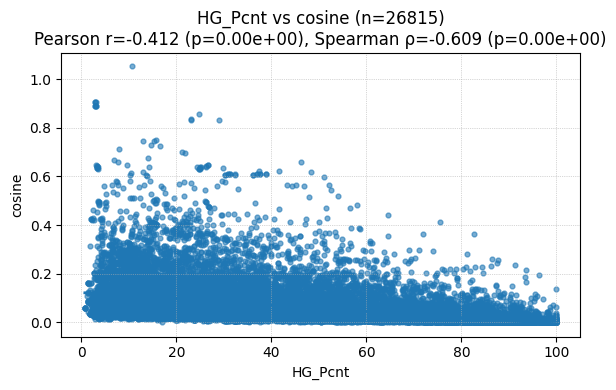

{'n': 26815, 'pearson_r': -0.41214907794396444, 'pearson_p': 0.0, 'spearman_rho': -0.6085696218434901, 'spearman_p': 0.0, 'slope': -0.0012829636690791422, 'intercept': 0.12259860464170762}


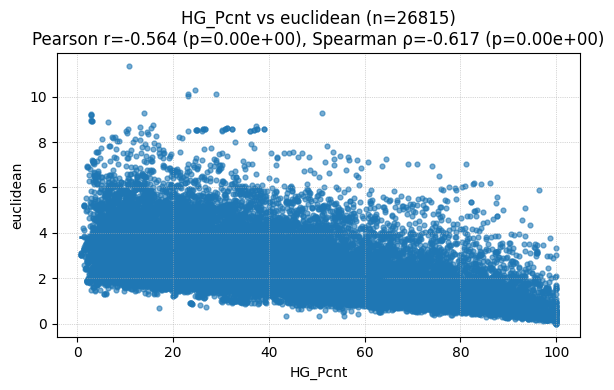

{'n': 26815, 'pearson_r': -0.5644881918482125, 'pearson_p': 0.0, 'spearman_rho': -0.6165541306849582, 'spearman_p': 0.0, 'slope': -0.029363636558355624, 'intercept': 3.8191689595283336}


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

def plot_and_correlate(df: pd.DataFrame,
                       x_col: str = "HG_Pcnt",
                       y_col: str = "cosine",
                       out_path: str | None = None):
    # 1) Clean data (drop NaN/inf)
    x = pd.to_numeric(df[x_col], errors="coerce")
    y = pd.to_numeric(df[y_col], errors="coerce")
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask].to_numpy()
    y = y[mask].to_numpy()
    n = x.size

    if n < 3:
        raise ValueError("Not enough valid points after cleaning for correlation/fit.")

    # 2) Correlations
    pearson_r, pearson_p = stats.pearsonr(x, y)
    spearman_rho, spearman_p = stats.spearmanr(x, y)

    # 3) Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, s=12, alpha=0.6)
    # Best-fit line (least squares)
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 200)
    plt.plot(xs, m * xs + b, linewidth=2)

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{x_col} vs {y_col} (n={n})\n"
              f"Pearson r={pearson_r:.3f} (p={pearson_p:.2e}), "
              f"Spearman ρ={spearman_rho:.3f} (p={spearman_p:.2e})")
    plt.grid(True, linestyle=":", linewidth=0.5)

    if out_path:
        plt.tight_layout()
        plt.savefig(out_path, dpi=200, bbox_inches="tight")
        plt.close()
    else:
        plt.tight_layout()
        plt.show()

    return {
        "n": n,
        "pearson_r": float(pearson_r),
        "pearson_p": float(pearson_p),
        "spearman_rho": float(spearman_rho),
        "spearman_p": float(spearman_p),
        "slope": float(m),
        "intercept": float(b),
    }

# Example:
stats_dict = plot_and_correlate(merged, x_col="HG_Pcnt", y_col="cosine", out_path=None)
print(stats_dict)
stats_dict = plot_and_correlate(merged, x_col="HG_Pcnt", y_col="euclidean", out_path=None)
print(stats_dict)


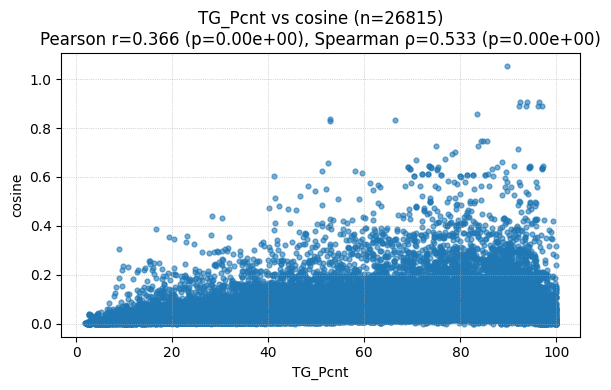

{'n': 26815, 'pearson_r': 0.36614995534312056, 'pearson_p': 0.0, 'spearman_rho': 0.5333256048077005, 'spearman_p': 0.0, 'slope': 0.001144368730259415, 'intercept': 0.003933588977185974}


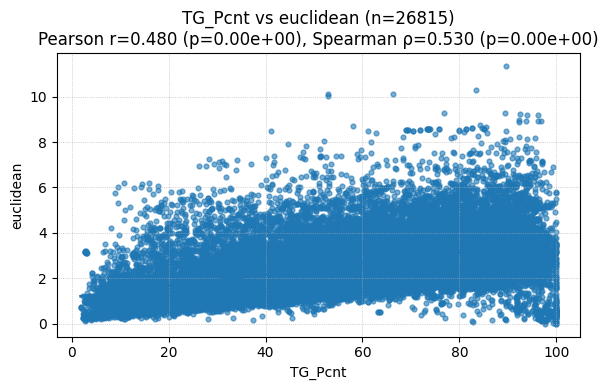

{'n': 26815, 'pearson_r': 0.47979145069881995, 'pearson_p': 0.0, 'spearman_rho': 0.5303879791022524, 'spearman_p': 0.0, 'slope': 0.02505846445880171, 'intercept': 1.1674401361121851}


In [33]:
fusion_tail_distances = pd.read_csv("/scratch/pranamlab/sophie/SiameseCat/siamesecat/data_files/embedding_dists/fusondb/fusion_head_distances_max2046AAs.csv")
mergedt = pd.merge(
    fusion_tail_distances,
    correlation_df[["seq_id","HG_seq_id","TG_seq_id","TG_Pcnt"]],
    how="left",
    on=["seq_id","HG_seq_id","TG_seq_id"]
)
stats_dict = plot_and_correlate(mergedt, x_col="TG_Pcnt", y_col="cosine", out_path=None)
print(stats_dict)
stats_dict = plot_and_correlate(mergedt, x_col="TG_Pcnt", y_col="euclidean", out_path=None)
print(stats_dict)


# Short sequences only

In [38]:
hg_length_dict = dict(zip(fusion_data["HG_seq_id"],fusion_data["HG_Length"]))
tg_length_dict = dict(zip(fusion_data["TG_seq_id"],fusion_data["TG_Length"]))
fusion_length_dict = dict(zip(fusion_data["seq_id"],fusion_data["Fusion_Length"]))

In [39]:
merged["HG_Length"] = merged["HG_seq_id"].map(hg_length_dict)
merged["Fusion_Length"] = merged["seq_id"].map(fusion_length_dict)

mergedt["TG_Length"] = mergedt["TG_seq_id"].map(hg_length_dict)
mergedt["Fusion_Length"] = mergedt["seq_id"].map(fusion_length_dict)

display(merged.head())
display(mergedt.head())

,seq_id,HG_seq_id,TG_seq_id,cosine,euclidean,HG_Pcnt,HG_Length,Fusion_Length
0,seq1,htseq1,htseq5300,0.133249,4.747875,4.61,495.0,564
1,seq2,htseq1,htseq5300,0.113640,4.042943,3.44,495.0,786
2,seq3,htseq1,htseq2156,0.024175,1.779211,62.92,495.0,534
3,seq4,htseq1,htseq2156,0.024715,1.791263,60.40,495.0,548
4,seq7,htseq2,htseq3747,0.027221,1.815135,56.46,1454.0,379


,seq_id,HG_seq_id,TG_seq_id,cosine,euclidean,TG_Pcnt,TG_Length,Fusion_Length
0,seq1,htseq1,htseq5300,0.133249,4.747875,90.78,NaN,564
1,seq2,htseq1,htseq5300,0.113640,4.042943,95.17,NaN,786
2,seq3,htseq1,htseq2156,0.024175,1.779211,40.07,930.0,534
3,seq4,htseq1,htseq2156,0.024715,1.791263,41.61,930.0,548
4,seq7,htseq2,htseq3747,0.027221,1.815135,43.54,530.0,379


In [40]:
merged_under1022 = merged.loc[
    (merged["Fusion_Length"]<=1022) & 
    (merged["HG_Length"]<=1022)
].reset_index(drop=True)
print(len(merged_under1022))
mergedt_under1022 = mergedt.loc[
    (mergedt["Fusion_Length"]<=1022) & 
    (mergedt["TG_Length"]<=1022)
].reset_index(drop=True)
print(len(mergedt_under1022))

17871
10824


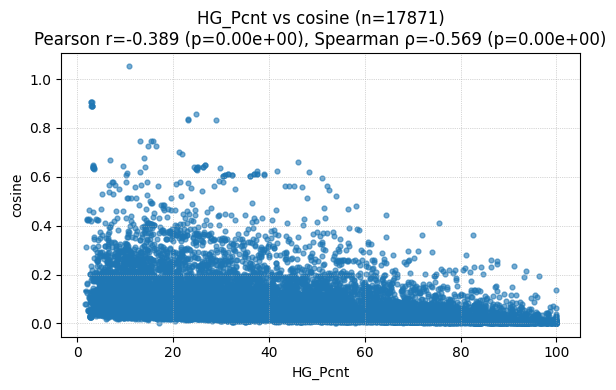

{'n': 17871, 'pearson_r': -0.38941207877083156, 'pearson_p': 0.0, 'spearman_rho': -0.5692011973938006, 'spearman_p': 0.0, 'slope': -0.0013605136839287962, 'intercept': 0.13407922916635737}


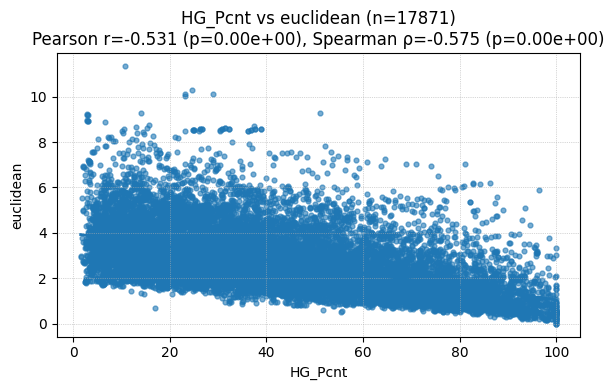

{'n': 17871, 'pearson_r': -0.5309430623939043, 'pearson_p': 0.0, 'spearman_rho': -0.5752862018272321, 'spearman_p': 0.0, 'slope': -0.029193026314114825, 'intercept': 3.9739116133307606}


In [41]:
stats_dict = plot_and_correlate(merged_under1022, x_col="HG_Pcnt", y_col="cosine", out_path=None)
print(stats_dict)
stats_dict = plot_and_correlate(merged_under1022, x_col="HG_Pcnt", y_col="euclidean", out_path=None)
print(stats_dict)

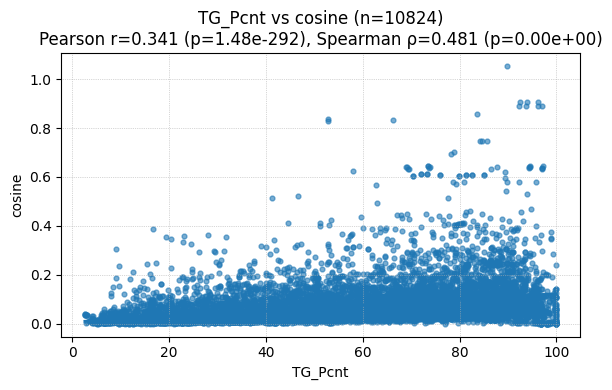

{'n': 10824, 'pearson_r': 0.34082800134378555, 'pearson_p': 1.4786390457706584e-292, 'spearman_rho': 0.4812668823805321, 'spearman_p': 0.0, 'slope': 0.001150904368568702, 'intercept': 0.007456357633774735}


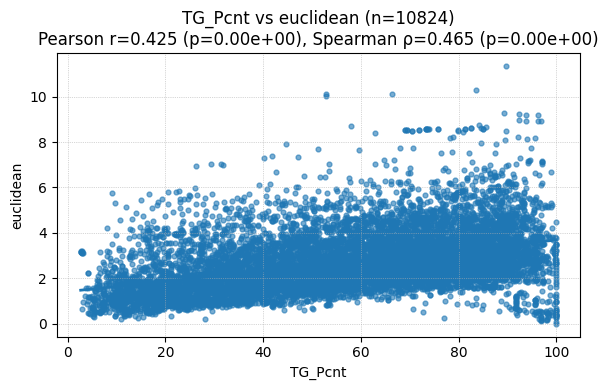

{'n': 10824, 'pearson_r': 0.4254890733141333, 'pearson_p': 0.0, 'spearman_rho': 0.46463126547103784, 'spearman_p': 0.0, 'slope': 0.02267152930849148, 'intercept': 1.4204153280909244}


In [43]:
stats_dict = plot_and_correlate(mergedt_under1022, x_col="TG_Pcnt", y_col="cosine", out_path=None)
print(stats_dict)
stats_dict = plot_and_correlate(mergedt_under1022, x_col="TG_Pcnt", y_col="euclidean", out_path=None)
print(stats_dict)

In [44]:
mergedt_under1022.loc[
    mergedt_under1022["TG_Pcnt"]==100
]

,seq_id,HG_seq_id,TG_seq_id,cosine,euclidean,TG_Pcnt,TG_Length,Fusion_Length
190,seq684,htseq78,htseq77,6.753206e-05,0.066571,100.0,377.0,376
513,seq2260,htseq263,htseq3845,5.102652e-02,2.695729,100.0,148.0,159
751,seq3299,htseq372,htseq2283,3.298080e-02,2.366237,100.0,793.0,297
846,seq3643,htseq410,htseq411,1.660049e-03,0.356148,100.0,999.0,998
1150,seq4567,htseq511,htseq639,2.406868e-01,4.464567,100.0,405.0,275
2126,seq8393,htseq986,htseq3673,1.272306e-01,3.769685,100.0,476.0,184
2472,seq9847,htseq1168,htseq389,1.104225e-01,3.518284,100.0,607.0,405
2587,seq10258,htseq1238,htseq518,8.305949e-02,3.255841,100.0,975.0,317
2822,seq11354,htseq1385,htseq1659,4.403752e-02,2.759954,100.0,452.0,123
2920,seq11778,htseq1428,htseq3614,5.702740e-02,3.189005,100.0,926.0,939
